# Imports 

In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


sys.path.insert(1, '../')



from tsad.base.pipeline import Pipeline
from tsad.base.wrappers import SklearnWrapper



from tsad.tasks.eda import HighLevelDatasetAnalysisTask, TimeDiscretizationTask
from tsad.tasks.eda import FindNaNTask, EquipmentDowntimeTask
from tsad.tasks.preprocess import ScalingTask, ValueRangeProcessingTask, ResampleProcessingTask 
from tsad.tasks.preprocess import FeatureProcessingTask, SplitByNaNTask, PrepareSeqSamplesTask
from tsad.tasks.deep_learning_anomaly_detection import ResidualAnomalyDetectionTask
from tsad.tasks.deep_learning_forecasting import DeepLeaningTimeSeriesForecastingTask


# Creating custom task by using Sklearn Wrapper
StandardScalerTask = SklearnWrapper(StandardScaler)

from tsad.base.datasets import load_skab


# Data loading

In [2]:
dataset = load_skab()
columns = dataset.feature_names
targets = dataset.target_names
df = dataset.frame

In [3]:
df.index.levels[0]

Index(['air/0', 'air/1', 'fluid/0', 'fluid/1', 'fluid/2', 'fluid/3', 'fluid/4',
       'fluid/5', 'rotor/0', 'rotor/1', 'rotor/2', 'rotor/3', 'rotor/4',
       'temperature/0', 'valve1/0', 'valve1/1', 'valve1/10', 'valve1/11',
       'valve1/12', 'valve1/13', 'valve1/14', 'valve1/15', 'valve1/2',
       'valve1/3', 'valve1/4', 'valve1/5', 'valve1/6', 'valve1/7', 'valve1/8',
       'valve1/9', 'valve2/0', 'valve2/1', 'valve2/2', 'valve2/3'],
      dtype='object', name='experiment')

# Train Test Split

In [4]:
test_datasets = ['valve1/0', 'valve2/0', 'fluid/0']
train_raw = df.drop(test_datasets,level=0).droplevel(level=0)
test_raw = df.loc[test_datasets].droplevel(level=0)

# Making custom task

In [5]:
from sklearn.preprocessing import StandardScaler
StandardScalerTask = SklearnWrapper(StandardScaler)

# Making and fit pipeline

## Hello world case

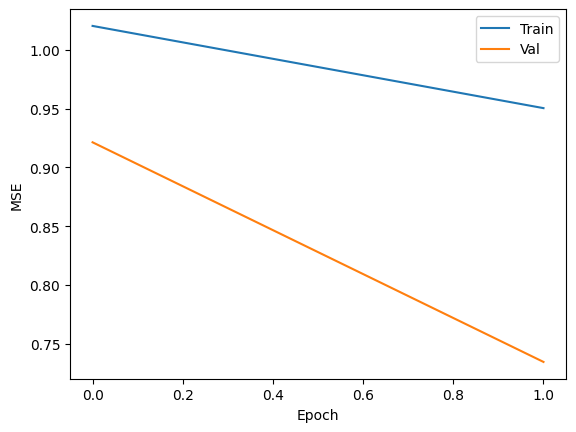

Epoch: 02 
	Train Loss: 0.950 
	 Val. Loss: 0.735 

Epoch: 01 
	Train Loss: 1.020 
	 Val. Loss: 0.921 


After choosing the best model:
Test Loss: 1.028


In [6]:
from tsad.pipelines import multivatiateTimeSeriesDeepLearningForecastingTaskSet

simple_pipeline = Pipeline(multivatiateTimeSeriesDeepLearningForecastingTaskSet)
y_pred_train = simple_pipeline.fit(train_raw,n_epochs=2)

## Advanced Case

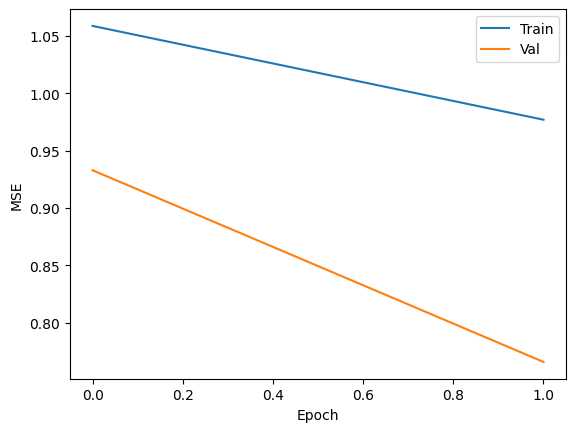

Epoch: 02 
	Train Loss: 0.977 
	 Val. Loss: 0.766 

Epoch: 01 
	Train Loss: 1.059 
	 Val. Loss: 0.933 


After choosing the best model:
Test Loss: 1.064
CPU times: total: 7.05 s
Wall time: 5.63 s


In [7]:
%%time
pipeline = Pipeline([
    HighLevelDatasetAnalysisTask(),
    TimeDiscretizationTask(freq_tobe_approach='custom',FREQ_TOBE='1s'),
    FindNaNTask(),
    EquipmentDowntimeTask(),
    ResampleProcessingTask(),
    StandardScalerTask(),
    FeatureProcessingTask(),
    SplitByNaNTask(),
    PrepareSeqSamplesTask(len_seq=10),
    DeepLeaningTimeSeriesForecastingTask(),
], show=False)
y_pred_train = pipeline.fit(train_raw,n_epochs=2)

# Inference of pipeline

In [8]:
y_pred = simple_pipeline.predict(test_raw)

Пропущено 5 датастов, из-за того что saples слишком малов в датасете. (len_seq + points_ahead + gap -1 <= len(df))


# Getting y_true

In [9]:
raw_pipeline = Pipeline([
    HighLevelDatasetAnalysisTask(),
    TimeDiscretizationTask(freq_tobe_approach='custom',FREQ_TOBE='1s'),# freq_tobe='1s'),
    FindNaNTask(),
    EquipmentDowntimeTask(),
    ResampleProcessingTask(),
    StandardScalerTask(),
    FeatureProcessingTask(),
    SplitByNaNTask(),
    PrepareSeqSamplesTask(len_seq=10,test_size=0,what_to_shuffle='nothing')])
_, _, y_true, _ = raw_pipeline.fit(test_raw)

None
1s
Пропущено 5 датастов, из-за того что saples слишком малов в датасете. (len_seq + points_ahead + gap -1 <= len(df))


# Comparing

In [10]:
from sklearn.metrics import mean_squared_error as rmse

In [11]:
print(rmse(y_true=np.array(y_true).ravel(), y_pred=np.array(y_pred).ravel()))

1.2433941680080283
